# Lecture 23 – Data 100, Fall 2021

by Suraj Rampure

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from scipy.optimize import minimize
import sklearn.linear_model as lm

plt.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['lines.linewidth'] = 3
sns.set()

## Thresholding in Logistic Regression

So far, our logistic regression model predicts probabilities. But we originally set out on a mission to create a classifier. How can we use our predicted probabilities to create classifications?

Let's get back the NBA data we had last time.

In [2]:
df = pd.read_csv('nba.csv')
df["WON"] = df["WL"]
df["WON"] = df["WON"].replace("W", 1)
df["WON"] = df["WON"].replace("L", 0)
one_team = df.groupby("GAME_ID").first()
opponent = df.groupby("GAME_ID").last()
games = one_team.merge(opponent, left_index = True, right_index = True, suffixes = ["", "_OPP"])
games["FG_PCT_DIFF"] = games["FG_PCT"] - games["FG_PCT_OPP"]
games["PF_DIFF"] = games["PF"] - games["PF_OPP"]
games['WON'] = games['WL'].replace('L', 0).replace('W', 1)
games = games[['TEAM_NAME', 'MATCHUP', 'WON', 'FG_PCT_DIFF', 'PF_DIFF']]

In [3]:
games.head()

,TEAM_NAME,MATCHUP,WON,FG_PCT_DIFF,PF_DIFF
GAME_ID,,,,,
21700001,Boston Celtics,BOS @ CLE,0,-0.049,-1
21700002,Golden State Warriors,GSW vs. HOU,0,0.053,9
21700003,Charlotte Hornets,CHA @ DET,0,-0.030,-6
21700004,Indiana Pacers,IND vs. BKN,1,0.041,0
21700005,Orlando Magic,ORL vs. MIA,1,0.042,-2


Let's call this model `basic_model` since it only has one feature. (Eventually, we will use more features.) 

It is the same model we fit in the last lecture.

In [4]:
basic_model = lm.LogisticRegression(penalty = 'none', fit_intercept = False, solver = 'lbfgs')

In [5]:
basic_model.fit(games[['FG_PCT_DIFF']], games['WON'])

LogisticRegression(fit_intercept=False, penalty='none')

As before, we can use `.predict_proba` to get the predicted probabilities for each class under our logistic regression model.

In [6]:
basic_model.predict_proba(games[['FG_PCT_DIFF']])

array([[0.81733506, 0.18266494],
       [0.16510648, 0.83489352],
       [0.71450899, 0.28549101],
       ...,
       [0.37288695, 0.62711305],
       [0.94003495, 0.05996505],
       [0.95102413, 0.04897587]])

We can plot our model, too:

In [7]:
x_sorted = np.array(games['FG_PCT_DIFF'].sort_values()).reshape(len(games), 1)
basic_model_ps_sorted = basic_model.predict_proba(x_sorted)[:, 1]

points = go.Scatter(name = 'true observations', 
                   x = games['FG_PCT_DIFF'],
                   y = games['WON'],
                   mode = 'markers',
                   marker={'opacity':0.5})

lr_line = go.Scatter(name = 'Logistic Regression model', 
                    x = x_sorted.flatten(),
                    y = basic_model_ps_sorted)

fig = go.Figure([points, lr_line])
fig

We need to apply a **threshold** to convert these probabilities into class labels (1 or 0). We can define a function that takes in probabilities, and returns their values, thresholded:

In [8]:
def predict_at_threshold(prob, threshold):
    return np.where(prob >= threshold, 1, 0)

In [9]:
predict_at_threshold(np.array([0.2, 0.5, 0.8]), 0.4)

array([0, 1, 1])

Let's look at the resulting predictions for three different (arbitrarily chosen thresholds): $T = 0.25, T = 0.5, T = 0.75$.

In [10]:
ts = [0.25, 0.5, 0.75]

thresholds_df = pd.DataFrame()
basic_model_ps = basic_model.predict_proba(games[['FG_PCT_DIFF']])[:, 1]
thresholds_df['P(Y = 1 | x)'] = basic_model_ps

for t in ts:
    thresholds_df[f'T = {t}'] = predict_at_threshold(basic_model_ps, t)

In [11]:
thresholds_df

,P(Y = 1 | x),T = 0.25,T = 0.5,T = 0.75
0,0.182665,0,0,0
1,0.834894,1,1,1
2,0.285491,1,0,0
3,0.777950,1,1,1
4,0.783187,1,1,1
...,...,...,...,...
1225,0.996919,1,1,1
1226,0.891870,1,1,1
1227,0.627113,1,1,0
1228,0.059965,0,0,0


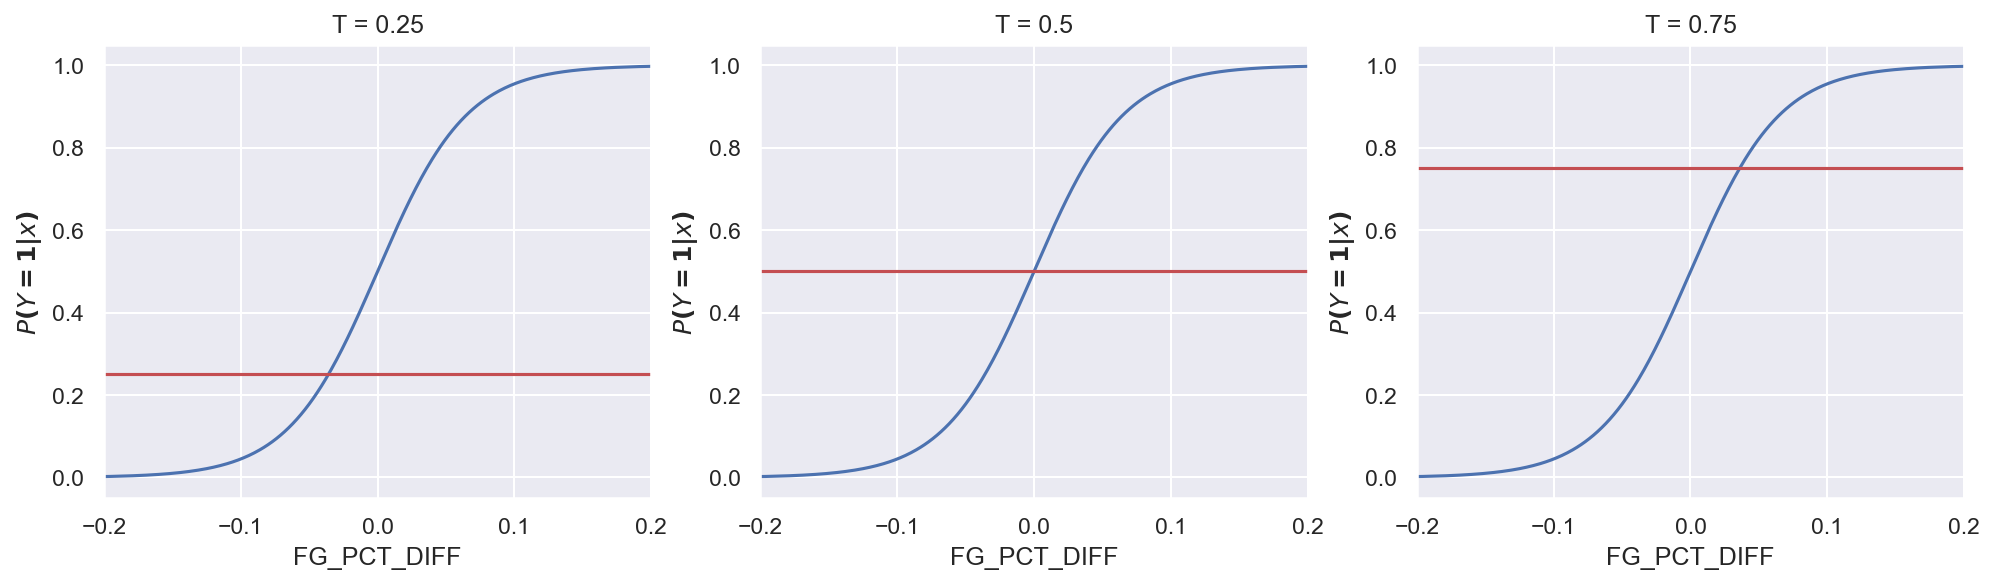

In [12]:
plt.figure(figsize = (16, 4))
for i, t in enumerate(ts):
    plt.subplot(1, 3, i + 1)
    plt.xlim(-0.2, 0.2)
    plt.plot(x_sorted, basic_model_ps_sorted);
    plt.plot([-0.3, 0.3], [t, t], color = 'r')
    plt.title(f'T = {t}')
    plt.xlabel('FG_PCT_DIFF')
    plt.ylabel(r'$P(Y = 1 | x)$')

As we increase our threshold, fewer and fewer observations are classified as being 1.

What about models with more than one feature? Well, if our model has any more than two features, we can't really visualize it. But with two (or three, if we include an intercept term), we can visualize it just fine.

Let's now use `FG_PCT_DIFF` and `PF_DIFF` to predict whether or not a team will win. `PF_DIFF` is the difference in the number of personal fouls your team and the other team were charged with.

In [13]:
better_model = lm.LogisticRegression(penalty = 'none', fit_intercept = True, solver = 'lbfgs')

In [14]:
better_model.fit(games[['FG_PCT_DIFF', 'PF_DIFF']], games['WON'])

LogisticRegression(penalty='none')

In [15]:
better_model.coef_

array([[34.70520847, -0.15994445]])

In [16]:
better_model.intercept_

array([0.03455392])

These results mean that our model makes predictions as

$$\hat{y} = P(Y = 1 | x) = \sigma(0.035 + 34.71 \cdot \text{FG_PCT_DIFF} - 0.160 \cdot \text{PF_DIFF})$$

Interpreting these coefficients, it seems to mean that having a positive `FG_PCT_DIFF` really helps your team's chances of winning, and having a positive `PF_DIFF` hurts your team's chances of winning.

In [17]:
games['FG_PCT_DIFF'].describe()

count    1230.000000
mean       -0.001329
std         0.075473
min        -0.251000
25%        -0.050000
50%        -0.002000
75%         0.048000
max         0.281000
Name: FG_PCT_DIFF, dtype: float64

In [18]:
games['PF_DIFF'].describe()

count    1230.000000
mean        0.301626
std         5.160492
min       -20.000000
25%        -3.000000
50%         0.000000
75%         4.000000
max        17.000000
Name: PF_DIFF, dtype: float64

In [19]:
num_points = 50 # increase for better resolution, but it will run more slowly. 

# if (num_points <= 100):

uvalues = np.linspace(-0.2, 0.2, num_points)
vvalues = np.linspace(-20, 20, num_points)
(u,v) = np.meshgrid(uvalues, vvalues)
thetas = np.vstack((u.flatten(),v.flatten()))

probs = [better_model.predict_proba(t.reshape(1, 2))[0, 1] for t in thetas.T]

probs_surface = go.Surface(x=u, y=v, z=np.reshape(probs, u.shape))

# opt_point = go.Scatter3d(x = [ahat], y = [bhat], z = [mse_for_height_model((ahat, bhat))],
#             mode = 'markers', name = 'optimal parameters',
#             marker=dict(size=10, color='gold'))

fig = go.Figure(data=[probs_surface])
# fig.add_trace(opt_point)

fig.update_layout(scene = dict(
    xaxis_title = "FG_PCT_DIFF",
    yaxis_title = "PF_DIFF",
    zaxis_title = "P(Y = 1 | x)"))


fig.show()

We can visualize thresholds here, too. It'll be a little inconvenient to this three times, so let's just show $T = 0.3$ (chosen arbitrarily):

In [20]:
num_points = 50 # increase for better resolution, but it will run more slowly. 

# if (num_points <= 100):

uvalues = np.linspace(-0.2, 0.2, num_points)
vvalues = np.linspace(-20, 20, num_points)
(u,v) = np.meshgrid(uvalues, vvalues)
thetas = np.vstack((u.flatten(),v.flatten()))

probs = [better_model.predict_proba(t.reshape(1, 2))[0, 1] for t in thetas.T]

probs_surface = go.Surface(x=u, y=v, z=np.reshape(probs, u.shape))

threshold_surface = go.Surface(x = u, y = v, z = 0.3 * np.ones_like(u), opacity = 0.8, name = 'T = 0.3')

fig = go.Figure(data=[probs_surface, threshold_surface])

fig.update_layout(scene = dict(
    xaxis_title = "FG_PCT_DIFF",
    yaxis_title = "PF_DIFF",
    zaxis_title = "P(Y = 1 | x)"))

fig.show()

## Evaluating classifiers

First, let's compute the **accuracy** of our `better_model`, when using $T = 0.5$ (the default in `scikit-learn`).

In [21]:
# Getting our predicted 1s and 0s
y_pred = better_model.predict(games[['FG_PCT_DIFF', 'PF_DIFF']])

# The proportion of times we classified correctly is the accuracy
better_model_accuracy = np.mean(y_pred == games['WON'])

better_model_accuracy

0.8170731707317073

As per usual, `scikit-learn` can do this for us. The `.score` method of a `LogisticRegression` classifier gives us the accuracy of it.

In [22]:
better_model.score(games[['FG_PCT_DIFF', 'PF_DIFF']], games['WON'])

0.8170731707317073

### Confusion matrix

Our good old friend `scikit-learn` has an in-built confusion matrix method (of course it does).

In [23]:
from sklearn.metrics import confusion_matrix

# Be careful – confusion_matrix takes in y_true as the first parameter and y_pred as the second.
# Don't mix these up!
cm = confusion_matrix(games['WON'], y_pred)
cm

array([[521, 104],
       [121, 484]], dtype=int64)

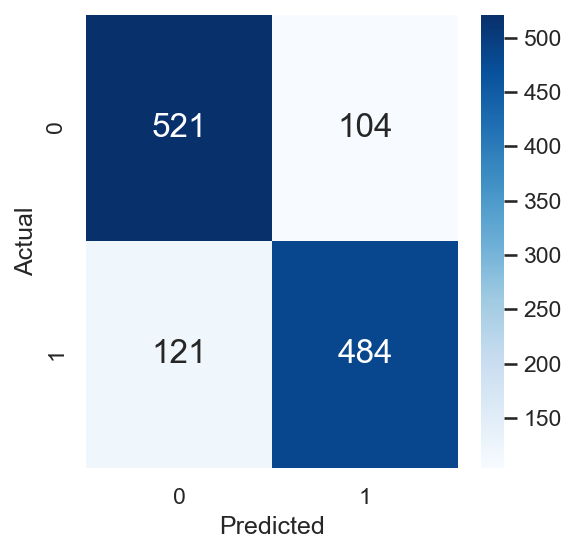

In [24]:
cm = confusion_matrix(games['WON'], y_pred)
sns.heatmap(cm, annot=True, fmt = 'd', cmap = 'Blues', annot_kws = {'size': 16})
plt.xlabel('Predicted')
plt.ylabel('Actual');

### Precision and Recall

We can also compute the number of TP, TN, FP, and TN for our classifier, and hence its precision and recall.

In [25]:
tp = np.sum((y_pred == 1) & (games['WON'] == 1))
tn = np.sum((y_pred == 0) & (games['WON'] == 0))
fp = np.sum((y_pred == 1) & (games['WON'] == 0))
fn = np.sum((y_pred == 0) & (games['WON'] == 1))

In [26]:
tp, tn, fp, fn

(484, 521, 104, 121)

These numbers match what we see in the confusion matrix above.

In [27]:
precision = tp / (tp + fp)
precision

0.8231292517006803

In [28]:
recall = tp / (tp + fn)
recall

0.8

It's important to remember that these values are all for the threshold of $T = 0.5$, which is `scikit-learn`'s default.

## Accuracy vs. threshold, Precision vs. threshold, Recall vs. threshold

We already have a function `predict_at_threshold`, which takes in a list of probabilities and a threshold and computes the predicted labels (1s and 0s) at that threshold.

Let's also create our own `accuracy_custom_threshold` function, that takes in
- a `model`
- a true `y`
- an `x`
- a `threshold`

And returns the accuracy of the predictions for our `model` with that threshold. Note that this function is not specific to our `better_model`, so we can use it later.

In [29]:
def accuracy_custom_threshold(model, X, y, threshold):
    predicted_probabilities = model.predict_proba(X)[:, 1]
    y_pred = predict_at_threshold(predicted_probabilities, threshold)
    return np.mean(y_pred == y)

In [30]:
accuracy_custom_threshold(better_model, games[['FG_PCT_DIFF', 'PF_DIFF']], games['WON'], 0.5)

0.8170731707317073

This is the same accuracy that `model.score` gave us before, so we should be good to go.

Let's plot what this accuracy looks like, for various thresholds:

In [31]:
thresholds = np.linspace(0, 1, 100)
accs = [accuracy_custom_threshold(better_model,
                                  games[['FG_PCT_DIFF', 'PF_DIFF']], 
                                  games['WON'],
                                  t) for t in thresholds]

In [32]:
fig = px.line(x=thresholds, y=accs)
fig.update_xaxes(title="Threshold")
fig.update_yaxes(title="Accuracy")

We will make similar helper functions for precision and recall, and make similar plots.

In [33]:
def precision_custom_threshold(model, X, y, threshold):
    predicted_probabilities = model.predict_proba(X)[:, 1]
    y_pred = predict_at_threshold(predicted_probabilities, threshold)
    tp = np.sum((y_pred == 1) & (y == 1))
    fp = np.sum((y_pred == 1) & (y == 0))
    return tp / (tp + fp)

precision_custom_threshold(better_model, games[['FG_PCT_DIFF', 'PF_DIFF']], games['WON'], 0.5)

0.8231292517006803

In [34]:
def recall_custom_threshold(model, X, y, threshold):
    predicted_probabilities = model.predict_proba(X)[:, 1]
    y_pred = predict_at_threshold(predicted_probabilities, threshold)
    tp = np.sum((y_pred == 1) & (y == 1))
    fn = np.sum((y_pred == 0) & (y == 1))
    return tp / (tp + fn)

recall_custom_threshold(better_model, games[['FG_PCT_DIFF', 'PF_DIFF']], games['WON'], 0.5)

0.8

In [35]:
precs = [precision_custom_threshold(better_model,
                                  games[['FG_PCT_DIFF', 'PF_DIFF']], 
                                  games['WON'],
                                  t) for t in thresholds]

recs = [recall_custom_threshold(better_model,
                                  games[['FG_PCT_DIFF', 'PF_DIFF']], 
                                  games['WON'],
                                  t) for t in thresholds]

<ipython-input-33-02ebabff2160>:6: RuntimeWarning:

invalid value encountered in longlong_scalars



In [36]:
fig = go.Figure()
fig.add_trace(go.Scatter(name = 'Precision', x = thresholds, y = precs))
fig.add_trace(go.Scatter(name = 'Recall', x = thresholds, y = recs))
fig.update_xaxes(title="Threshold")
fig.update_yaxes(title="Proportion")

## Precision-Recall Curves

We can also plot precision vs. recall.

In [37]:
fig = px.line(x=recs, y=precs, hover_name=thresholds)
fig.update_xaxes(title="Recall")
fig.update_yaxes(title="Precision")

`scikit-learn` can also do this for us.

In [38]:
from sklearn.metrics import precision_recall_curve

In [39]:
precision, recall, threshold = precision_recall_curve(games['WON'], 
                                                              better_model.predict_proba(games[['FG_PCT_DIFF', 'PF_DIFF']])[:, 1])


In [40]:
fig = px.line(x=recall[:-1], y = precision[:-1], hover_name=threshold)
fig.update_xaxes(title="Recall")
fig.update_yaxes(title="Precision")
fig

Same thing, just a bit more granular.

We can also plot a ROC curve (explained in lecture).

In [41]:
from sklearn.metrics import roc_curve

In [42]:
fpr, tpr, threshold = roc_curve(games['WON'], 
                               better_model.predict_proba(games[['FG_PCT_DIFF', 'PF_DIFF']])[:, 1])

In [43]:
fig = px.line(x=fpr, y = tpr, hover_name=threshold)
fig.update_xaxes(title="False Positive Rate")
fig.update_yaxes(title="True Positive Rate")
fig

For a random classifier:

In [44]:
fpr, tpr, threshold = roc_curve(games['WON'], np.random.uniform(0, 1, len(games['WON'])))

In [45]:
fig = px.line(x=fpr, y = tpr, hover_name=threshold)
fig.update_xaxes(title="False Positive Rate")
fig.update_yaxes(title="True Positive Rate")
fig

## Decision Boundaries

In [46]:
from matplotlib.colors import ListedColormap

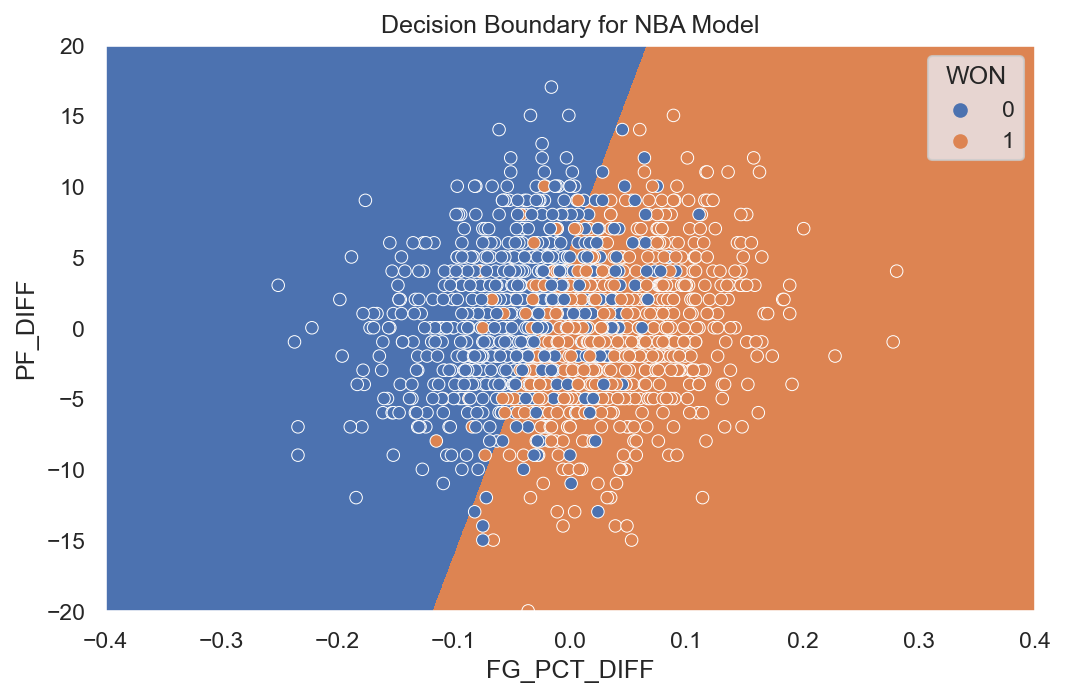

In [47]:
plt.figure(figsize = (8, 5))
sns_cmap = ListedColormap(np.array(sns.color_palette())[0:2, :])
xx, yy = np.meshgrid(np.linspace(-0.4, 0.4, 2000), np.linspace(-20, 20, 2000))
Z_string = predict_at_threshold(
    better_model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1],
    0.3)
categories, Z_int = np.unique(Z_string, return_inverse = True)
Z_int = Z_int.reshape(xx.shape)
plt.contourf(xx, yy, Z_int, cmap = sns_cmap)
sns.scatterplot(data = games, x = 'FG_PCT_DIFF', y = 'PF_DIFF', hue = 'WON')
plt.title('Decision Boundary for NBA Model');
# plt.savefig('withoutpts.png')

In [48]:
better_model.coef_

array([[34.70520847, -0.15994445]])

In [49]:
better_model.intercept_

array([0.03455392])

$$P(Y = 1 | x) = \sigma(0.035 + 34.705 \cdot \text{FG_PCT_DIFF} - 0.160 \cdot \text{PF_DIFF})$$

$$\sigma(0.035 + 34.705 \cdot \text{FG_PCT_DIFF} - 0.160 \cdot \text{PF_DIFF}) = 0.3$$

$$\boxed{0.035 + 34.705 \cdot \text{FG_PCT_DIFF} - 0.160 \cdot \text{PF_DIFF} = \sigma^{-1}(0.3)}$$

In [50]:
def f(x):
    return (1/0.160) * (0.035 + 34.705*x - np.log(0.3 / 0.7))

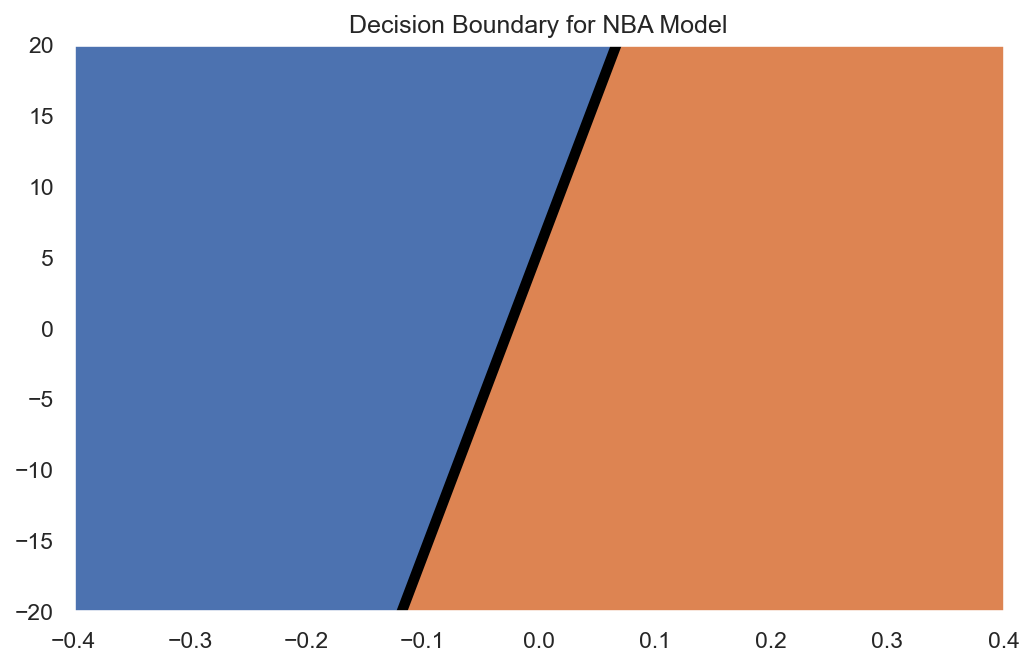

In [51]:
plt.figure(figsize = (8, 5))
sns_cmap = ListedColormap(np.array(sns.color_palette())[0:2, :])
xx, yy = np.meshgrid(np.linspace(-0.4, 0.4, 2000), np.linspace(-20, 20, 2000))
Z_string = predict_at_threshold(
    better_model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1],
    0.3)
categories, Z_int = np.unique(Z_string, return_inverse = True)
Z_int = Z_int.reshape(xx.shape)
plt.contourf(xx, yy, Z_int, cmap = sns_cmap)
# sns.scatterplot(data = games, x = 'FG_PCT_DIFF', y = 'PF_DIFF', hue = 'WON')
plt.title('Decision Boundary for NBA Model');

xs = np.linspace(-0.4, 0.4, 50)
ys = f(xs)
plt.plot(xs, ys, color = 'black', linewidth=5)
plt.ylim(-20, 20);

## Linear Separability

Consider the following toy dataset.

In [52]:
X_toy = np.array([-1, 1])
y_toy = np.array([1, 0])

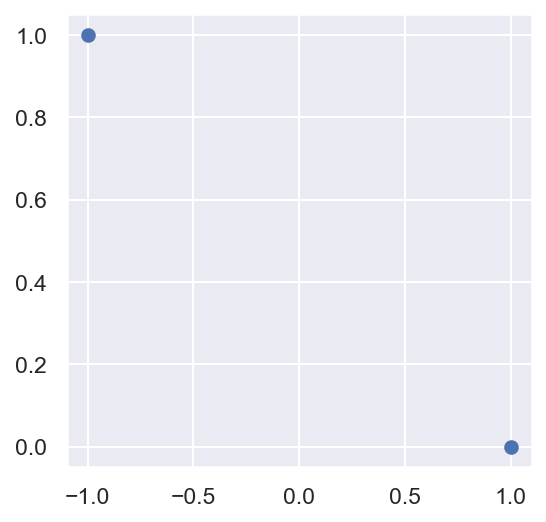

In [53]:
plt.scatter(X_toy.flatten(), y_toy);

Let's look at the mean cross-entropy loss surface for this toy dataset, and a single feature model $\hat{y} = \sigma(\theta x)$.

In [54]:
sigma = lambda t: 1 / (1 + np.e**(-t))

def cross_entropy(y, yhat):
    return - y * np.log(yhat) - (1 - y) * np.log(1 - yhat)

In [55]:
def mce_loss_single_arg_toy(theta):
    y_hat = sigma(X_toy * theta)
    return np.mean(cross_entropy(y_toy, y_hat))

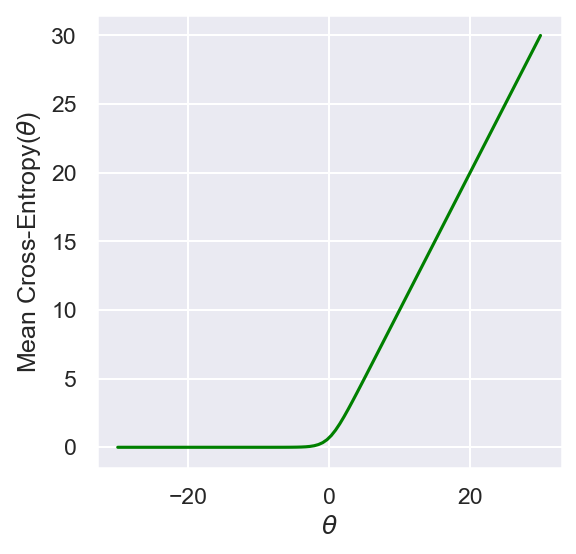

In [56]:
thetas = np.linspace(-30, 30, 100)
plt.plot(thetas, [mce_loss_single_arg_toy(theta) for theta in thetas], color = 'green')
plt.ylabel(r'Mean Cross-Entropy($\theta$)')
plt.xlabel(r'$\theta$');

But using **regularization**:

In [57]:
def mce_regularized_loss_single_arg_toy(theta, reg):
    return mce_loss_single_arg_toy(theta) + reg * theta**2 

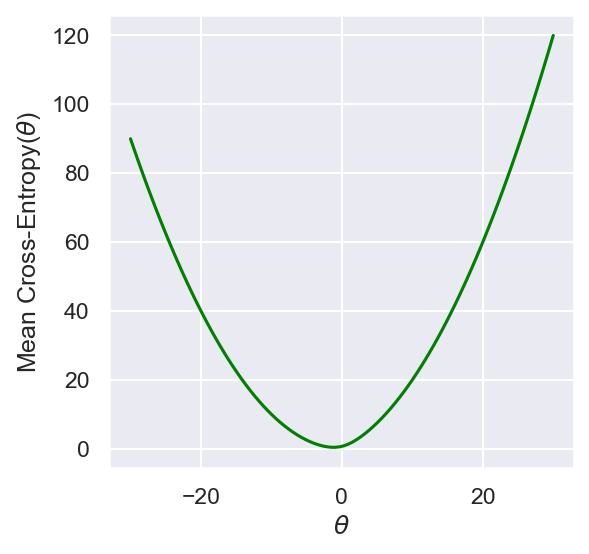

In [58]:
thetas = np.linspace(-30, 30, 100)
plt.plot(thetas, [mce_regularized_loss_single_arg_toy(theta, 0.1) for theta in thetas], color = 'green')
plt.ylabel(r'Mean Cross-Entropy($\theta$)')
plt.xlabel(r'$\theta$');

Let's look at another example dataset to illustrate linear separability.

In [59]:
iris = sns.load_dataset('iris')

In [60]:
iris

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


The following data is linearly separable:

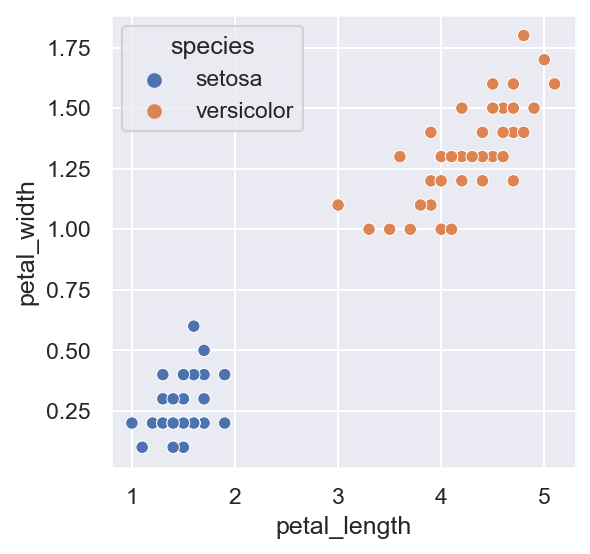

In [61]:
sns.scatterplot(data = iris[iris['species'] != 'virginica'],
               x = 'petal_length',
               y = 'petal_width',
               hue = 'species');

And the following here is not:

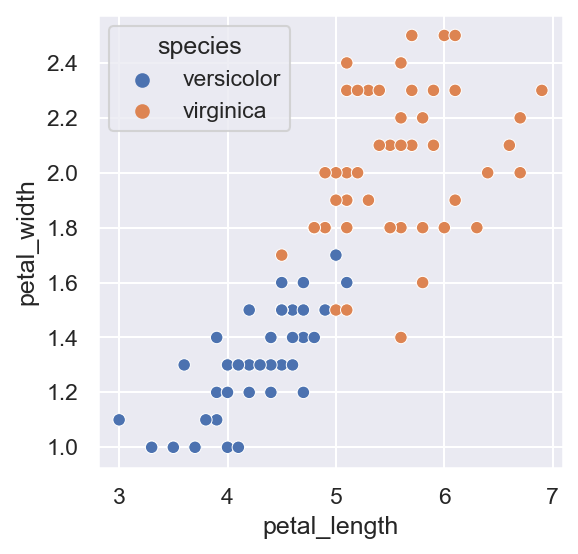

In [62]:
sns.scatterplot(data = iris[iris['species'] != 'setosa'],
               x = 'petal_length',
               y = 'petal_width',
               hue = 'species');

## Full Demo

As a demo of the model fitting process from end-to-end, let's fit a regularized LogisticRegression model on the `iris` data, while performing a train/test split.

Let's try and predict the species of our `iris`. But, there are three possible values of `species` right now:

In [63]:
iris['species'].unique()

array(['setosa', 'versicolor', 'virginica'], dtype=object)

So let's create a new column `is_versicolor` that is 1 if the iris is a versicolor, and a 0 otherwise.

In [64]:
iris['is_versicolor'] = (iris['species'] == 'versicolor').astype(int)

In [65]:
iris

,sepal_length,sepal_width,petal_length,petal_width,species,is_versicolor
0,5.1,3.5,1.4,0.2,setosa,0
1,4.9,3.0,1.4,0.2,setosa,0
2,4.7,3.2,1.3,0.2,setosa,0
3,4.6,3.1,1.5,0.2,setosa,0
4,5.0,3.6,1.4,0.2,setosa,0
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica,0
146,6.3,2.5,5.0,1.9,virginica,0
147,6.5,3.0,5.2,2.0,virginica,0
148,6.2,3.4,5.4,2.3,virginica,0


In [66]:
cols = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

In [67]:
from sklearn.model_selection import train_test_split

In [68]:
iris_train, iris_test = train_test_split(iris, test_size = 0.2)

First, let's look at the coefficients if we fit without regularization:

In [69]:
iris_model_no_reg = lm.LogisticRegression(penalty = 'none', solver = 'lbfgs')
iris_model_no_reg.fit(iris_train[cols], iris_train['is_versicolor'])

LogisticRegression(penalty='none')

In [70]:
iris_model_no_reg.coef_

array([[ 0.11432197, -3.21210806,  0.73584894, -2.07450044]])

In [71]:
iris_model_no_reg.intercept_

array([7.83236405])

Now let's fit with regularization, using the default value of `C` (the regularization hyperparameter in `scikit-learn`):

In [72]:
iris_model_reg = lm.LogisticRegression(penalty = 'l2', solver = 'lbfgs')
iris_model_reg.fit(iris_train[cols], iris_train['is_versicolor'])

LogisticRegression()

In [73]:
iris_model_reg.coef_

array([[-0.04976749, -2.08322584,  0.44110229, -0.98876264]])

In [74]:
iris_model_reg.intercept_

array([5.26933114])

We can see the coefficients on the regularized model are significantly smaller.

Let's evaluate the training and testing accuracy of both models – regularized and not.

In [75]:
iris_model_no_reg.score(iris_train[cols], iris_train['is_versicolor'])

0.7333333333333333

In [76]:
iris_model_reg.score(iris_train[cols], iris_train['is_versicolor'])

0.725

Unsurprisingly, the regularized model performs worse on the training data.

In [77]:
iris_model_no_reg.score(iris_test[cols], iris_test['is_versicolor'])

0.8

In [78]:
iris_model_reg.score(iris_test[cols], iris_test['is_versicolor'])

0.7666666666666667

In this case, they both happened to perform the same on the test data. Interesting!

**Question:** What did we forget to do here (that we should always do when performing regularized linear or logistic regression)?